# nanoGPT: Глубокое погружение в архитектуру

В этом блокноте мы детально изучим реализацию nanoGPT, загрузим реальные веса и посмотрим на внутреннее устройство слоев.

In [1]:
import torch
import torch.nn as nn
import sys
import os
import inspect
import matplotlib.pyplot as plt

from src.model import GPTLanguageModel, Block, MultiHeadAttention, Head, FeedFoward

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Устройство: {device}")

Using device: mps
Using device: mps
Устройство: mps


## 1. Загрузка модели и весов

Загрузим модель и чекпоинт `model_ckpt.pt`.

In [2]:
model = GPTLanguageModel().to(device)

# Загружаем чекпоинт через symlink nanoGPT-lab
ckpt_path = 'nanoGPT-lab/model_ckpt.pt'

if os.path.exists(ckpt_path):
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    print(f"✅ Чекпоинт {ckpt_path} успешно загружен.")
else:
    print(f"⚠️  ВНИМАНИЕ: Файл {ckpt_path} не найден. Работаем с неинициализированными весами.")

✅ Чекпоинт nanoGPT-lab/model_ckpt.pt успешно загружен.


## 2. Иерархия слоев PyTorch

Давайте рекурсивно посмотрим на все модули модели.

In [3]:
def print_structure(module, indent=0):
    for name, child in module.named_children():
        print("  " * indent + f"- {name}: {type(child).__name__}")
        print_structure(child, indent + 1)

print("Структура GPTLanguageModel:")
print_structure(model)

Структура GPTLanguageModel:
- token_embedding_table: Embedding
- position_embedding_table: Embedding
- blocks: Sequential
  - 0: Block
    - sa: MultiHeadAttention
      - heads: ModuleList
        - 0: Head
          - key: Linear
          - query: Linear
          - value: Linear
          - dropout: Dropout
        - 1: Head
          - key: Linear
          - query: Linear
          - value: Linear
          - dropout: Dropout
        - 2: Head
          - key: Linear
          - query: Linear
          - value: Linear
          - dropout: Dropout
        - 3: Head
          - key: Linear
          - query: Linear
          - value: Linear
          - dropout: Dropout
        - 4: Head
          - key: Linear
          - query: Linear
          - value: Linear
          - dropout: Dropout
        - 5: Head
          - key: Linear
          - query: Linear
          - value: Linear
          - dropout: Dropout
      - proj: Linear
      - dropout: Dropout
    - ffwd: FeedFoward
   

## 3. Детальный осмотр первого блока Transformer

Посмотрим на веса слоев в `model.blocks[0]`.

In [4]:
first_block = model.blocks[0]
print(f"Осмотр блока: {first_block}\n")

for name, param in first_block.named_parameters():
    print(f"{name:40} | Shape: {str(list(param.shape)):20} | Mean: {param.mean().item():.4f}")

Осмотр блока: Block(
  (sa): MultiHeadAttention(
    (heads): ModuleList(
      (0-5): 6 x Head(
        (key): Linear(in_features=384, out_features=64, bias=False)
        (query): Linear(in_features=384, out_features=64, bias=False)
        (value): Linear(in_features=384, out_features=64, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (proj): Linear(in_features=384, out_features=384, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (ffwd): FeedFoward(
    (net): Sequential(
      (0): Linear(in_features=384, out_features=1536, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1536, out_features=384, bias=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)

sa.heads.0.key.weight                    | Shape: [64, 384]            | Mean: 0.0000
sa.heads.0.query.weight                  | Shape: [64, 384]

## 4. Low-Rank (SVD) анализ весов Attention

Возьмем матрицу Query одной из голов и посмотрим на её спектр сингулярных чисел.

Матрица весов Query Head 0: torch.Size([64, 384])


/var/folders/s5/f_k8f4gn19l2f8nb2fvwb2sh0000gn/T/ipykernel_69316/4224254027.py:6: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  U, S, V = torch.svd(W)


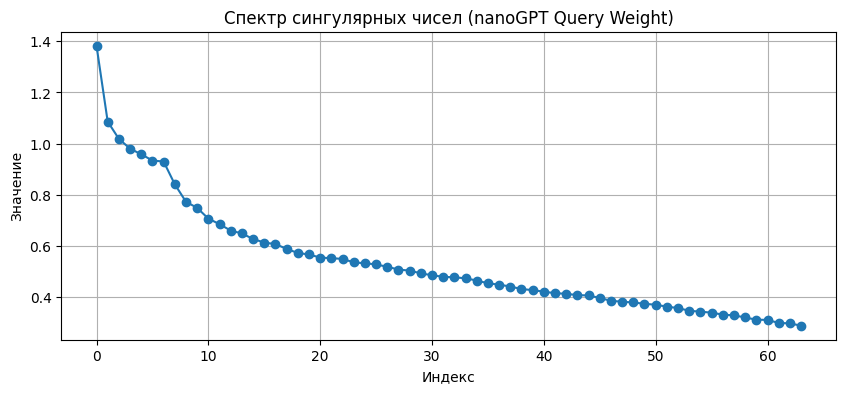

Количество 'значимых' компонент (выше 10% от максимума): 64 из 64


In [5]:
import numpy as np
# Извлекаем веса
W = first_block.sa.heads[0].query.weight.data
print(f"Матрица весов Query Head 0: {W.shape}")

U, S, V = torch.svd(W)
S_np = S.detach().cpu().numpy()

plt.figure(figsize=(10, 4))
plt.plot(S_np, 'o-')
plt.title("Спектр сингулярных чисел (nanoGPT Query Weight)")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.grid(True)
plt.show()

energy_90 = np.sum(S_np > (S_np[0] * 0.1))
print(f"Количество 'значимых' компонент (выше 10% от максимума): {energy_90} из {len(S_np)}")